Intro: The idea behind this approach was to take all the 2018-2019 data and use it to build a seperate model for each 2020 period. Differences in the overall accuracy of each model as well as shifts in the importance of different features to the model might indicate COVID-related change. 

This approach initially seemed pretty promising. The kitchen sink model (the model built on all available features) assigned the highest correlation coefficients to features which appeared highly topical, primarily author names: Ibram X. Kendi and Ta-Nehisi Coates during the height of the Black Lives Matter Protests, Sally Rooney as Normal People was released as a television series, Jeanine Cummins while American Dirt recieved significant press attention. Based on that model, it appeared that monthly review counts would be best predicted by understanding pop cultural trends at that moment rather than overall historical trends. The correlation matrix (in the feature selection notebook) supported the assumption that historical review counts would be less important. It seemed like we were going to find something very cool! 

However, the feature selection testing was a damp towel. For this process, I started with the baseline model and tested the impact of adding new features one at a time. Every single feature addition degraded model performance: we ended up right back at the baseline model. That model is exciting in that it performs fairly well, but it is of minimal use in analyzing 2020 trends. With potentially topical features no longer included, I'm not sure that the approach of building seperate models for each 2020 month is still viable. It might be best to drop the approach entirely, although taking a more granualar approach to feature selection could also make sense. 

In [84]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import aggregator as ag
import monthly_modeler as mm

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [85]:
data_file_name_review = "distributed_data_collection/databases/review_data.csv"
data_file_name_book = "distributed_data_collection/databases/book_data.csv"
data_file_name_subject = "subject_matching/data/sub_feat_all.csv"

start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 9, 30)

Because one of the key questions of the project is going to be the importance of historical data versus other attributes of books, I would like to see a preview of the correlation between each period. I'm interested in how strongly periods correlate with one another as well as general trends around correlation clusters.

In [86]:
book_columns_history = ["num_reviews", "num_ratings"]

data_aggregator_history = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_history, start_date, end_date, "month")
data_history = data_aggregator_history.aggregate("by_book")

if "book_id" in data_history.columns:
    data_history.drop(columns = "book_id", inplace = True)
    
corr = data_history.corr()
#print(corr.describe())

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.


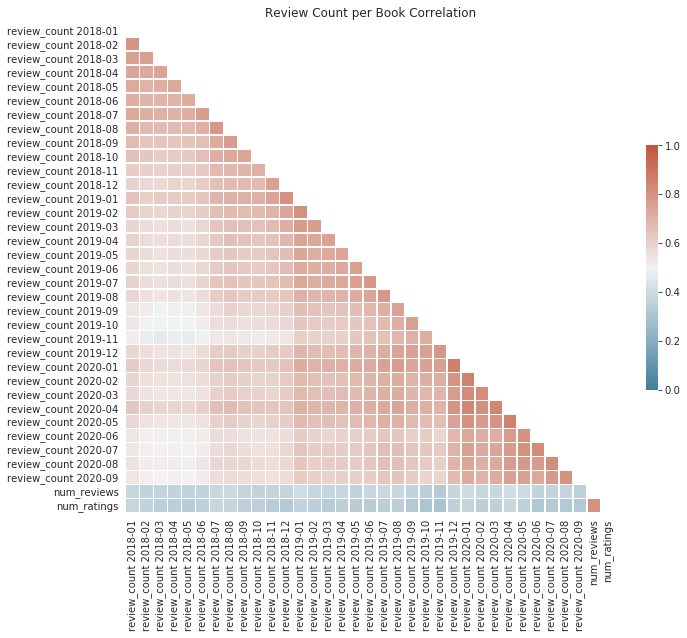

In [87]:
with sns.axes_style("white"):    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.title("Review Count per Book Correlation")

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.5, vmin = 0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

It looks like overall, recent history as measured by the review counts is much more closely correlated with each month than the total history (num_reviews, num_ratings). We assumed that reviews would primarily be constant with classics such as Harry Potter dominating, but that doesn't actually appear to be the case. 

Looking at how the scraped review counts correlated with one another, it looks like the closer time periods (ie, last month and next month) are more closely correlated with a given period than the same month YA. We had anticipated significant seasonality (back-to-school books, summer reading, etc), but again, that doesn't appear to be the case. 

One additional observation: the fact that our periods correlate with another suggest that our data sample is working well. If our sample was too small, we would expect to see more noise between each month.

The first test that I want to run: comparing baseline methodology (linear only) to methodology with multiple regressions (linear, ridge, lasso) and regularization parameters. The multiple regression types should either win or tie, but never let it be said I don't validate my work. This is going to be called "check01" with the different inputs referred to as "baseline" or "new_param."

In [88]:
print(data_history.describe())

       review_count 2018-01  review_count 2018-02  review_count 2018-03  \
count          16303.000000          16303.000000          16303.000000   
mean               0.766975              0.531988              0.549347   
std                2.445928              1.618752              1.616837   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                1.000000              1.000000              1.000000   
max               77.000000             60.000000             51.000000   

       review_count 2018-04  review_count 2018-05  review_count 2018-06  \
count          16303.000000          16303.000000          16303.000000   
mean               0.520702              0.512176              0.551800   
std                1.537906              1.512459              1.600975   
min                0.000

In [5]:
alpha_list_baseline = [1]
regression_types_list_baseline = ["linear"]
is_log_options_baseline = [False, True] 

alpha_list_new_param = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list_new_param = ["linear", "ridge", "lasso"]
is_log_options_new_param = [False, True]

In this case, we only need one dataset.

In [6]:
book_columns_check01 = ["num_reviews", "num_ratings", "avg_rating"]

data_aggregator_check01 = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_check01, start_date, end_date, "month")
data_aggregator_check01.aggregate("by_book")
data_aggregator_check01.sparsity_filter(2)

time_periods_post_check01 = data_aggregator_check01.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 0/37 columns. 37 columns remaining.


Now we want to run the models several times and retain the r2_test values. 

In [7]:
check01_results_df = pd.DataFrame({"post_period":time_periods_post_check01} ) 

for test_num in range(1,11):
    
    print("Beginning test number {}...".format(test_num))
    
    data_train_check01, data_test_check01 = data_aggregator_check01.get_train_test_split(0.75)
    
    print("Generating baseline models...")
    
    regression_processor_baseline = mm.Regression_Processor(data_train_check01, data_test_check01, time_periods_post_check01, regression_types_list_baseline, is_log_options_baseline, alpha_list_baseline)
    performance_df_baseline, model_dict_baseline = regression_processor_baseline.get_optimal_models()
    
    print("Generating new parameter models...")
    
    regression_processor_new_param = mm.Regression_Processor(data_train_check01, data_test_check01, time_periods_post_check01, regression_types_list_new_param, is_log_options_new_param, alpha_list_new_param)
    performance_df_new_param, model_dict_new_param = regression_processor_new_param.get_optimal_models()
    
    check01_results_df["test_{}_baseline".format(test_num)] = performance_df_baseline.r2_test
    check01_results_df["test_{}_new_param".format(test_num)] = performance_df_new_param.r2_test
    
check01_results_df["post_period"] = check01_results_df["post_period"].apply(lambda text: text.replace("review_count ", ""))

10/18 models processed
18/18 models processed
10/414 models processed
20/414 models processed
30/414 models processed
40/414 models processed
50/414 models processed
60/414 models processed
70/414 models processed
80/414 models processed
90/414 models processed
100/414 models processed
110/414 models processed
120/414 models processed
130/414 models processed
140/414 models processed
150/414 models processed
160/414 models processed
170/414 models processed
180/414 models processed
190/414 models processed
200/414 models processed
210/414 models processed
220/414 models processed
230/414 models processed
240/414 models processed
250/414 models processed
260/414 models processed
270/414 models processed
280/414 models processed
290/414 models processed
300/414 models processed
310/414 models processed
320/414 models processed
330/414 models processed
340/414 models processed
350/414 models processed
360/414 models processed
370/414 models processed
380/414 models processed
390/414 model

In [31]:
mean_results_check_01 = check01_results_df.mean()
print(mean_results_check_01.round(3))

test_1_baseline      0.655
test_1_new_param     0.655
test_2_baseline      0.620
test_2_new_param     0.620
test_3_baseline      0.675
test_3_new_param     0.675
test_4_baseline      0.638
test_4_new_param     0.638
test_5_baseline      0.629
test_5_new_param     0.629
test_6_baseline      0.667
test_6_new_param     0.667
test_7_baseline      0.681
test_7_new_param     0.681
test_8_baseline      0.699
test_8_new_param     0.699
test_9_baseline      0.582
test_9_new_param     0.584
test_10_baseline     0.671
test_10_new_param    0.671
dtype: float64


As predicted, this check was unnecessary... The two methodologies perform identically with the baseline data. It must be picking the linear model every time. 

The next test that I want to run: comparing the baseline features with the broader set of scraped features. This is going to be called "check01" with the different inputs referred to as "baseline" or "new_scraped."

In [38]:
book_columns_check_baseline = ["num_reviews", "num_ratings", "avg_rating"]
book_columns_new_scraped = ["num_reviews", "num_ratings", "avg_rating", "book_language", "series", "book_author"]

alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list = ["linear", "ridge", "lasso"]
#is_log_options = [False, True]
is_log_options = [False]

In this case, I want to pull one dataset out of aggregator and then adjust the feature list within the test. It's a little annoying, but the idea is to make sure that the check is comparing the same train/test split.

In [39]:
data_aggregator_check02 = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_new_scraped, start_date, end_date, "month")
data_aggregator_check02.aggregate("by_book")
data_aggregator_check02.sparsity_filter(2)

time_periods_post_check02 = data_aggregator_check02.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 10,112/12,295 columns. 2,183 columns remaining.


In [40]:
check02_results_df = pd.DataFrame({"post_period":time_periods_post_check01} ) 

#IDENTIFYING COLUMNS TO DROP

temp_df, temp_df_other = data_aggregator_check02.get_train_test_split(0.75)
column_list = temp_df.columns
cols_to_drop = []
remove_keywords = ["author", "series", "language"]

for col in column_list:
    drop_bool = any(val in col for val in remove_keywords)
    
    if drop_bool:
        cols_to_drop.append(col)

for test_num in range(1,6):
    
    print("Beginning test number {}...".format(test_num))
    
    data_train_check02_new_scraped, data_test_check02_new_scraped = data_aggregator_check02.get_train_test_split(0.75)
    data_train_check02_baseline, data_test_check02_baseline = data_train_check02_new_scraped.copy(), data_test_check02_new_scraped.copy()
            
    for col in cols_to_drop:
        data_train_check02_baseline.drop(columns = col, inplace = True)
        data_test_check02_baseline.drop(columns = col, inplace = True)
        
    print("Generating baseline models...")
    
    regression_processor_baseline = mm.Regression_Processor(data_train_check02_baseline, data_test_check02_baseline, time_periods_post_check02, regression_types_list, is_log_options, alpha_list)
    performance_df_baseline, model_dict_baseline = regression_processor_baseline.get_optimal_models()
          
    print("Generating new scraped models...")
    
    regression_processor_new_scraped = mm.Regression_Processor(data_train_check02_new_scraped, data_test_check02_new_scraped, time_periods_post_check02, regression_types_list, is_log_options, alpha_list)
    performance_df_new_scraped, model_dict_new_scraped = regression_processor_new_scraped.get_optimal_models()
    
    check02_results_df["test_{}_baseline".format(test_num)] = performance_df_baseline.r2_test
    check02_results_df["test_{}_new_scraped".format(test_num)] = performance_df_new_scraped.r2_test
    
check02_results_df["post_period"] = check02_results_df["post_period"].apply(lambda text: text.replace("review_count ", ""))

Beginning test number 1...
Generating baseline models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
Generating new scraped models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170

In [41]:
mean_results_check_02 = check02_results_df.mean()
print(mean_results_check_02.round(3))

test_1_baseline       0.550
test_1_new_scraped    0.524
test_2_baseline       0.579
test_2_new_scraped    0.562
test_3_baseline       0.640
test_3_new_scraped    0.600
test_4_baseline       0.752
test_4_new_scraped    0.725
test_5_baseline       0.681
test_5_new_scraped    0.674
dtype: float64


It's interesting to see that the methodology with the additional features performs worse than the older version every time. However realistically, I should probably be checking one "feature group" at a time. I want to check these in order of least values to most values in order to reduce overall processing time. Also, I will need to check cleaned authors versus uncleaned authors. 

Just as a note, I recognize that it would be better to check every possible combination of individual features rather than going stepwise through each group of features. However, I would like to do this in a reasonable amount of time. I also feel like the regularization should be taking care of the fine details, so it is okay that I am working in rough outlines.  

In [43]:
num_author_values = 0
num_language_values = 0
num_series_values = 0

for val in column_list:
    if "book_author" in val:
        num_author_values +=1
    elif "language" in val:
        num_language_values +=1
    elif "series" in val:
        num_series_values +=1
        
print("""
Author: {}
Language: {}
Series: {}
""".format(num_author_values, num_language_values, num_series_values))


Author: 1335
Language: 22
Series: 789



It looks like I'm starting with language.

In [49]:
book_columns_check_baseline = ["num_reviews", "num_ratings", "avg_rating"]
book_columns_lan = ["num_reviews", "num_ratings", "avg_rating", "book_language"]

alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list = ["linear", "ridge", "lasso"]
#is_log_options = [False, True]
is_log_options = [False]

In [50]:
data_aggregator_check02_lan = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_lan, start_date, end_date, "month")
data_aggregator_check02_lan.aggregate("by_book")
data_aggregator_check02_lan.sparsity_filter(2)

time_periods_post_check02_lan = data_aggregator_check02_lan.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 14/73 columns. 59 columns remaining.


In [54]:
check02_lan_results_df = pd.DataFrame({"post_period":time_periods_post_check01} ) 

#IDENTIFYING COLUMNS TO DROP

temp_df, temp_df_other = data_aggregator_check02_lan.get_train_test_split(0.75)
column_list = temp_df.columns
cols_to_drop = []
remove_keywords = ["language"]

for col in column_list:
    drop_bool = any(val in col for val in remove_keywords)
    
    if drop_bool:
        cols_to_drop.append(col)

for test_num in range(1,6):
    
    print("Beginning test number {}...".format(test_num))
    
    data_train_check02_lan, data_test_check02_lan = data_aggregator_check02_lan.get_train_test_split(0.75)
    data_train_check02_baseline, data_test_check02_baseline = data_train_check02_lan.copy(), data_test_check02_lan.copy()
            
    for col in cols_to_drop:
        data_train_check02_baseline.drop(columns = col, inplace = True)
        data_test_check02_baseline.drop(columns = col, inplace = True)
        
    print("Generating baseline models...")
    
    regression_processor_baseline = mm.Regression_Processor(data_train_check02_baseline, data_test_check02_baseline, time_periods_post_check02, regression_types_list, is_log_options, alpha_list)
    performance_df_baseline, model_dict_baseline = regression_processor_baseline.get_optimal_models()
          
    print("Generating language models...")
    
    regression_processor_lan = mm.Regression_Processor(data_train_check02_lan, data_test_check02_lan, time_periods_post_check02_lan, regression_types_list, is_log_options, alpha_list)
    performance_df_lan, model_dict_lan = regression_processor_lan.get_optimal_models()
    
    check02_lan_results_df["test_{}_baseline".format(test_num)] = performance_df_baseline.r2_test
    check02_lan_results_df["test_{}_lan".format(test_num)] = performance_df_lan.r2_test
    
check02_lan_results_df["post_period"] = check02_lan_results_df["post_period"].apply(lambda text: text.replace("review_count ", ""))

Beginning test number 1...
Generating baseline models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
Generating new scraped models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170

In [56]:
mean_results_check_02_lan = check02_lan_results_df.mean()
print(mean_results_check_02_lan.round(3))

test_1_baseline    0.604
test_1_lan         0.603
test_2_baseline    0.654
test_2_lan         0.654
test_3_baseline    0.660
test_3_lan         0.659
test_4_baseline    0.652
test_4_lan         0.651
test_5_baseline    0.709
test_5_lan         0.708
dtype: float64


Based on these results, I will not be including the language features in the model. They appear to make performance slightly worse. The next value to test is series. 

In [58]:
book_columns_check_baseline = ["num_reviews", "num_ratings", "avg_rating"]
book_columns_ser = ["num_reviews", "num_ratings", "avg_rating", "series"]

alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list = ["linear", "ridge", "lasso"]
#is_log_options = [False, True]
is_log_options = [False]

In [59]:
data_aggregator_check02_ser = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_ser, start_date, end_date, "month")
data_aggregator_check02_ser.aggregate("by_book")
data_aggregator_check02_ser.sparsity_filter(2)

time_periods_post_check02_ser = data_aggregator_check02_ser.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 3,177/4,003 columns. 826 columns remaining.


In [60]:
check02_ser_results_df = pd.DataFrame({"post_period":time_periods_post_check01} ) 

#IDENTIFYING COLUMNS TO DROP

temp_df, temp_df_other = data_aggregator_check02_ser.get_train_test_split(0.75)
column_list = temp_df.columns
cols_to_drop = []
remove_keywords = ["series"]

for col in column_list:
    drop_bool = any(val in col for val in remove_keywords)
    
    if drop_bool:
        cols_to_drop.append(col)

for test_num in range(1,6):
    
    print("Beginning test number {}...".format(test_num))
    
    data_train_check02_ser, data_test_check02_ser = data_aggregator_check02_ser.get_train_test_split(0.75)
    data_train_check02_baseline, data_test_check02_baseline = data_train_check02_ser.copy(), data_test_check02_ser.copy()
            
    for col in cols_to_drop:
        data_train_check02_baseline.drop(columns = col, inplace = True)
        data_test_check02_baseline.drop(columns = col, inplace = True)
        
    print("Generating baseline models...")
    
    regression_processor_baseline = mm.Regression_Processor(data_train_check02_baseline, data_test_check02_baseline, time_periods_post_check02, regression_types_list, is_log_options, alpha_list)
    performance_df_baseline, model_dict_baseline = regression_processor_baseline.get_optimal_models()
          
    print("Generating series models...")
    
    regression_processor_ser = mm.Regression_Processor(data_train_check02_ser, data_test_check02_ser, time_periods_post_check02_ser, regression_types_list, is_log_options, alpha_list)
    performance_df_ser, model_dict_ser = regression_processor_ser.get_optimal_models()
    
    check02_ser_results_df["test_{}_baseline".format(test_num)] = performance_df_baseline.r2_test
    check02_ser_results_df["test_{}_ser".format(test_num)] = performance_df_ser.r2_test
    
check02_ser_results_df["post_period"] = check02_ser_results_df["post_period"].apply(lambda text: text.replace("review_count ", ""))

Beginning test number 1...
Generating baseline models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
Generating new scraped models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170

In [61]:
mean_results_check_02_ser = check02_ser_results_df.mean()
print(mean_results_check_02_ser.round(3))

test_1_baseline    0.587
test_1_ser         0.577
test_2_baseline    0.645
test_2_ser         0.631
test_3_baseline    0.679
test_3_ser         0.666
test_4_baseline    0.695
test_4_ser         0.678
test_5_baseline    0.656
test_5_ser         0.642
dtype: float64


Series data also makes the model worse. I remember that part of the scraper being particularly irritating to write. I really thought it would matter! So much for my theory that the best predictor is Harry Potter.

Author is up next. I guess I will start with the clean data since I think that one is more likely to work out.  

In [64]:
book_columns_check_baseline = ["num_reviews", "num_ratings", "avg_rating"]
book_columns_auth = ["num_reviews", "num_ratings", "avg_rating", "book_author"]

alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list = ["linear", "ridge", "lasso"]
#is_log_options = [False, True]
is_log_options = [False]

In [65]:
data_aggregator_check02_auth_clean = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_auth, start_date, end_date, "month", clean_authors = True)
data_aggregator_check02_auth_clean.aggregate("by_book")
data_aggregator_check02_auth_clean.sparsity_filter(2)

time_periods_post_check02_auth_clean = data_aggregator_check02_auth_clean.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Cleaning Author Data...
Author Data Cleaned...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 5,572/7,072 columns. 1,500 columns remaining.


In [68]:
check02_auth_clean_results_df = pd.DataFrame({"post_period":time_periods_post_check02_auth_clean} ) 

#IDENTIFYING COLUMNS TO DROP

temp_df, temp_df_other = data_aggregator_check02_auth_clean.get_train_test_split(0.75)
column_list = temp_df.columns
cols_to_drop = []
remove_keywords = ["author"]

for col in column_list:
    drop_bool = any(val in col for val in remove_keywords)
    
    if drop_bool:
        cols_to_drop.append(col)

for test_num in range(1,6):
    
    print("Beginning test number {}...".format(test_num))
    
    data_train_check02_auth_clean, data_test_check02_auth_clean = data_aggregator_check02_auth_clean.get_train_test_split(0.75)
    data_train_check02_baseline, data_test_check02_baseline = data_train_check02_auth_clean.copy(), data_test_check02_auth_clean.copy()
            
    for col in cols_to_drop:
        data_train_check02_baseline.drop(columns = col, inplace = True)
        data_test_check02_baseline.drop(columns = col, inplace = True)
        
    print("Generating baseline models...")
    
    regression_processor_baseline = mm.Regression_Processor(data_train_check02_baseline, data_test_check02_baseline, time_periods_post_check02_auth_clean, regression_types_list, is_log_options, alpha_list)
    performance_df_baseline, model_dict_baseline = regression_processor_baseline.get_optimal_models()
          
    print("Generating author clean models...")
    
    regression_processor_auth_clean = mm.Regression_Processor(data_train_check02_auth_clean, data_test_check02_auth_clean, time_periods_post_check02_auth_clean, regression_types_list, is_log_options, alpha_list)
    performance_df_auth_clean, model_dict_auth_clean = regression_processor_auth_clean.get_optimal_models()
    
    check02_auth_clean_results_df["test_{}_baseline".format(test_num)] = performance_df_baseline.r2_test
    check02_auth_clean_results_df["test_{}_auth_clean".format(test_num)] = performance_df_auth_clean.r2_test
    
check02_auth_clean_results_df["post_period"] = check02_auth_clean_results_df["post_period"].apply(lambda text: text.replace("review_count ", ""))

Beginning test number 1...
Generating baseline models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
Generating new scraped models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170

In [69]:
mean_results_check_02_auth_clean = check02_auth_clean_results_df.mean()
print(mean_results_check_02_auth_clean.round(3))

test_1_baseline      0.666
test_1_auth_clean    0.641
test_2_baseline      0.605
test_2_auth_clean    0.589
test_3_baseline      0.664
test_3_auth_clean    0.648
test_4_baseline      0.636
test_4_auth_clean    0.617
test_5_baseline      0.578
test_5_auth_clean    0.569
dtype: float64


ARGH. Cleaned author features degrade the model. That said, I can see an argument that because the model is so much more informative, we might want to keep them. The model isn't THAT much worse, about -0.02 degredation in r^2.

Another option would be to do a more rigorous feature selection against the author features. I wouldn't be surprised if some authors are much more powerful than others, although I would have expected the regularization to capture that. 

In [70]:
book_columns_check_baseline = ["num_reviews", "num_ratings", "avg_rating"]
book_columns_auth = ["num_reviews", "num_ratings", "avg_rating", "book_author"]

alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list = ["linear", "ridge", "lasso"]
#is_log_options = [False, True]
is_log_options = [False]

In [71]:
data_aggregator_check02_auth_raw = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_auth, start_date, end_date, "month")
data_aggregator_check02_auth_raw.aggregate("by_book")
data_aggregator_check02_auth_raw.sparsity_filter(2)

time_periods_post_check02_auth_raw = data_aggregator_check02_auth_raw.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 6,921/8,293 columns. 1,372 columns remaining.


In [72]:
check02_auth_raw_results_df = pd.DataFrame({"post_period":time_periods_post_check02_auth_raw} ) 

#IDENTIFYING COLUMNS TO DROP

temp_df, temp_df_other = data_aggregator_check02_auth_raw.get_train_test_split(0.75)
column_list = temp_df.columns
cols_to_drop = []
remove_keywords = ["author"]

for col in column_list:
    drop_bool = any(val in col for val in remove_keywords)
    
    if drop_bool:
        cols_to_drop.append(col)

for test_num in range(1,6):
    
    print("Beginning test number {}...".format(test_num))
    
    data_train_check02_auth_raw, data_test_check02_auth_raw = data_aggregator_check02_auth_raw.get_train_test_split(0.75)
    data_train_check02_baseline, data_test_check02_baseline = data_train_check02_auth_raw.copy(), data_test_check02_auth_raw.copy()
            
    for col in cols_to_drop:
        data_train_check02_baseline.drop(columns = col, inplace = True)
        data_test_check02_baseline.drop(columns = col, inplace = True)
        
    print("Generating baseline models...")
    
    regression_processor_baseline = mm.Regression_Processor(data_train_check02_baseline, data_test_check02_baseline, time_periods_post_check02_auth_raw, regression_types_list, is_log_options, alpha_list)
    performance_df_baseline, model_dict_baseline = regression_processor_baseline.get_optimal_models()
          
    print("Generating author raw models...")
    
    regression_processor_auth_raw = mm.Regression_Processor(data_train_check02_auth_raw, data_test_check02_auth_raw, time_periods_post_check02_auth_raw, regression_types_list, is_log_options, alpha_list)
    performance_df_auth_raw, model_dict_auth_raw = regression_processor_auth_raw.get_optimal_models()
    
    check02_auth_raw_results_df["test_{}_baseline".format(test_num)] = performance_df_baseline.r2_test
    check02_auth_raw_results_df["test_{}_auth_raw".format(test_num)] = performance_df_auth_raw.r2_test
    
check02_auth_raw_results_df["post_period"] = check02_auth_raw_results_df["post_period"].apply(lambda text: text.replace("review_count ", ""))

Beginning test number 1...
Generating baseline models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
Generating new scraped models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170

In [73]:
mean_results_check_02_auth_raw = check02_auth_raw_results_df.mean()
print(mean_results_check_02_auth_raw.round(3))

test_1_baseline    0.684
test_1_auth_raw    0.665
test_2_baseline    0.664
test_2_auth_raw    0.658
test_3_baseline    0.553
test_3_auth_raw    0.541
test_4_baseline    0.684
test_4_auth_raw    0.672
test_5_baseline    0.690
test_5_auth_raw    0.675
dtype: float64


I mean, at this point, it's not even a surprise. Uncleaned authors are out.

Now, I'm going to do the subject data. Bring on the long runtimes! This one is going to be called "check03," with the different versions called "baseline" and "subj."

In [74]:
book_columns_check_baseline = ["num_reviews", "num_ratings", "avg_rating"]

alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]
regression_types_list = ["linear", "ridge", "lasso"]
#is_log_options = [False, True]
is_log_options = [False]

In [78]:
data_aggregator_check03 = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns_check_baseline, start_date, end_date, "month", subject_file = data_file_name_subject)
data_aggregator_check03.aggregate("by_book")
data_aggregator_check03.sparsity_filter(2)

time_periods_post_check03 = data_aggregator_check03.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Cleaning Subject Data...
Subject Data Cleaned
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Merging Subject Data...
Subject Data Merged.
Applying Sparsity Filter...
Dropped 5/1,260 columns. 1,255 columns remaining.


In [81]:
check03_results_df = pd.DataFrame({"post_period":time_periods_post_check03} ) 

#IDENTIFYING COLUMNS TO DROP

temp_df, temp_df_other = data_aggregator_check03.get_train_test_split(0.75)
column_list = temp_df.columns
cols_to_drop = []
remove_keywords = ["subject"]

for col in column_list:
    drop_bool = any(val in col for val in remove_keywords)
    
    if drop_bool:
        cols_to_drop.append(col)

for test_num in range(1,6):
    
    print("Beginning test number {}...".format(test_num))
    
    data_train_check03_subj, data_test_check03_subj = data_aggregator_check03.get_train_test_split(0.75)
    data_train_check03_baseline, data_test_check03_baseline = data_train_check03_subj.copy(), data_test_check03_subj.copy()
            
    for col in cols_to_drop:
        data_train_check03_baseline.drop(columns = col, inplace = True)
        data_test_check03_baseline.drop(columns = col, inplace = True)
        
    print("Generating baseline models...")
    
    regression_processor_baseline = mm.Regression_Processor(data_train_check03_baseline, data_test_check03_baseline, time_periods_post_check03, regression_types_list, is_log_options, alpha_list)
    performance_df_baseline, model_dict_baseline = regression_processor_baseline.get_optimal_models()
          
    print("Generating subject models...")
    
    regression_processor_subj = mm.Regression_Processor(data_train_check03_subj, data_test_check03_subj, time_periods_post_check03, regression_types_list, is_log_options, alpha_list)
    performance_df_subj, model_dict_subj = regression_processor_subj.get_optimal_models()
    
    check03_results_df["test_{}_baseline".format(test_num)] = performance_df_baseline.r2_test
    check03_results_df["test_{}_subj".format(test_num)] = performance_df_subj.r2_test
    
check03_results_df["post_period"] = check03_results_df["post_period"].apply(lambda text: text.replace("review_count ", ""))

Beginning test number 1...
Generating baseline models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
Generating new scraped models...
10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170

In [82]:
mean_results_check_03 = check03_results_df.mean()
print(mean_results_check_03.round(3))

test_1_baseline    0.675
test_1_subj        0.652
test_2_baseline    0.676
test_2_subj        0.653
test_3_baseline    0.639
test_3_subj        0.627
test_4_baseline    0.694
test_4_subj        0.667
test_5_baseline    0.599
test_5_subj        0.584
dtype: float64


Subject data is out as well...this brings us back to square one. 